<a href="https://colab.research.google.com/github/xvh422/L4-Project/blob/main/Plot%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install eagleSqlTools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable

con = sql.connect("vwg533", password = "FZtn087h")

In [3]:
sim_name = 'RefL0100N1504'
sim_size = 100.
snapnums = [28, 19, 15, 10]
Results  = {}

for snapnum in snapnums:
    query = "SELECT \
              FOF.Group_M_Crit200 as m200, \
              SH.BlackHoleMass as bh, \
              SH.StarFormationRate as sfr, \
              SH.MassType_Star as star \
            FROM \
              %s_FOF as FOF, \
              %s_SubHalo as SH \
            WHERE \
              SH.SnapNum = %d and \
              SH.SubGroupNumber = 0 and \
              SH.MassType_Star > 0 and \
              FOF.Group_M_Crit200 > 1e10 and \
              SH.GroupID = FOF.GroupID" %(sim_name, sim_name, snapnum)
    Results[snapnum] = sql.execute_query(con, query)

In [4]:
#Replaces zeroes with the smallest nonzero value.
def log_with_zeros(data):
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

# Returns median x and y values within bins of size 'step' to make a line of "best fit"
def medians(xs, ys, min, max, step):
  xbins = np.arange(min, max+step, step)
  xmeds = np.empty(len(xbins))
  ymeds = np.empty(len(xbins))
  for i in range(len(ymeds)):
    yvals = ys[np.logical_and(xs > xbins[i], xs < (xbins[i]+step))]
    ymeds[i] = np.median(yvals)
    xvals = xs[np.logical_and(xs > xbins[i], xs < (xbins[i]+step))]
    xmeds[i] = np.median(xvals)
  return xmeds, ymeds

# Removes element from both arrays if one/both of them is zero
def remove_zeros_2(data1, data2):
  out_1 = []
  out_2 = []
  for i in range(len(data1)):
    if data1[i] == 0:
      out_1 = out_1
      out_2 = out_2
    elif data2[i] == 0:
      out_1 = out_1
      out_2 = out_2
    else:
      out_1 = out_1 + [data1[i]]
      out_2 = out_2 + [data2[i]]
  return np.array(out_1), np.array(out_2)

# Divides two arrays, but replaces #/0 with 0
def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


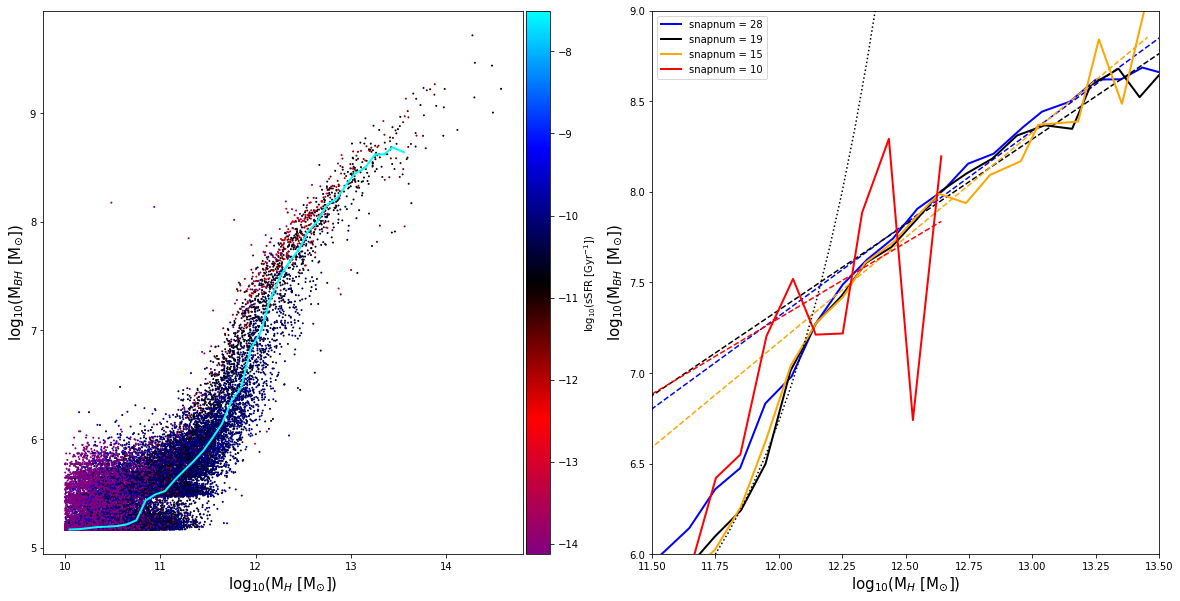

In [8]:
colours = ['blue', 'black', 'orange', 'red']

cvals = [-2, -1 , 0, 1 , 2]
colors = ["purple","red","black","blue","cyan"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)

sSFR1 = divide_with_zeros(Results[28]['sfr'], Results[28]['star'])
log_sSFR1 = log_with_zeros(sSFR1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))

im1 = ax1.scatter(log_with_zeros(Results[28]['m200']), log_with_zeros(Results[28]['bh']), c=log_sSFR1, cmap=cmap, s=1)
meds1 = medians(log_with_zeros(Results[28]['m200']), log_with_zeros(Results[28]['bh']), 10, 13.5, 0.1)
x1 = meds1[0]
y1 = meds1[1]
ax1.plot(x1, y1, linewidth=2, color='cyan')

ax1.set_xlabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])', fontsize=15)
ax1.set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])', fontsize=15)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = r'log$_{10}$(sSFR [Gyr$^{-1}$])')

for snapnum, colour in zip(snapnums, colours):
  meds = medians(log_with_zeros(Results[snapnum]['m200']), log_with_zeros(Results[snapnum]['bh']), 10, 13.5, 0.1)
  x = meds[0]
  y = meds[1]
  ax2.plot(x, y, linewidth=2, color=colour, label="snapnum = {0:2d}".format(snapnum))
  xl = x[np.logical_and(x > 12.25, x < 13.5)]
  yl = y[np.logical_and(x > 12.25, x < 13.5)]
  params = np.polyfit(xl, yl, 1)
  ax2.plot(x, params[0]*x + params[1], linestyle='dashed', color=colour)

xs1 = np.arange(11.5, 12.5, 0.05)
ys1 = 9**(xs1-11.75) + 5
ax2.plot(xs1, ys1, color='black', linestyle='dotted')

ax2.set_xlabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])', fontsize=15)
ax2.set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])', fontsize=15)
ax2.set_xlim(11.5, 13.5)
ax2.set_ylim(6, 9)
ax2.legend()

plt.savefig('Plot_3.jpeg')
plt.show()